
# 2016 Iowa Liquor Store Research 
### By Michael Costa 07/17 DSI-5
## Executive Summary:
A Iowa liquor store owner has approached me to do some exploratory data analysis of the states 2015 sales data, in hopes of gaining insight in where to build their next store. The data showed that Volume sold was correlated strongly with Sales in dollars and as a result we were able to isolate a few high volume counties that would be good candidates for new stores. My SLR modeling showed that increases in volume could predict state sales to stores in the counties Scott, Johnson and Polk, these three counties are markets that would be good investments, each with their own strengths. Polk has the capitol and state universities and seems to be the most populous. Therefore it isn’t surprising the volume there would be high, however they also have far more stores already than any other county in the state. From a return on investment perspective that makes Scott and Johnson possibly more desirable. The average sales per transaction are keeping pace with Polk however with much less total volume. The selling point here is that both counties have far less competition with fewer stores. I would relish the opportunity to put more time into the market research with additional information. Demographic data for the counties could be key in unlocking the potential of underserved markets in Iowa. I recommend our investor conducts some more exploratory research but this is a good start.
What follows are the steps I took to prepare the data for analysis and modeling and the results that garnered.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

## import libraries 

In [102]:
complete_set = pd.read_csv('/Users/natalie/Desktop/GA/Project_2_Data/Iowa_fullset.csv')
# ten_set = pd.read_csv('/Users/natalie/Desktop/GA/Project_2_Data/Iowa_Liquor_10pct.csv')
full_set = complete_set
# first imported the full set to clean up the data, now that I want to do analysis and model I will use the 10% and switch back later
## loading data into data frame

In [103]:
full_set.head()
#print head to get a feel for our data

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.5,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.6,2.54
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.5,1.19


In [104]:
full_set.columns = [c.replace(' ', '_').replace("(","").replace(")","")for c in full_set.columns]
   # cleaning up spaces and () in my column headers in maybe not the most elegant way.

In [6]:
def eda(dataframe):
    # This is the EDA function Ritika wrote and showed us. I still like using it alot.
    print "Missing Values \n", dataframe.isnull().sum(),"\n"
    print "Duplicate Rows \n", dataframe.duplicated().sum(),"\n" 
    print "Dataframe Types \n", dataframe.dtypes,"\n"
    print "Dataframe Shape \n", dataframe.shape,"\n"
    print "Dataframe Describe \n", dataframe.describe(include='all'),"\n"
    for feature in dataframe: # gives us unique counts for each column
        print feature
        print dataframe[feature].nunique()



In [7]:
# eda(full_set)

In [8]:
# df_5029 = full_set[full_set['Store Number'] == 5029]
# eda(df_5029)
# df_5029[df_5029['Category Name' == 'nan']
# checking one store for iragularites, exploring nan values

In [105]:
full_set["Date"] = pd.to_datetime(full_set["Date"], format='%m/%d/%Y')
# changing datetime by passing it the current format

In [10]:
# full_set['Date']
# checking corrected dates

In [11]:
# full_set[full_set.isnull().any(axis=1)]
# looking at nul values, alot of them seem to being missing geo data and category. makes sense to drop them it is onlt 16k in a 2mil set

In [106]:
df_nul = full_set.dropna()
#  dropping nul only 16k out of +2 mil

In [107]:
df = pd.DataFrame(df_nul)


In [108]:
df.drop_duplicates(inplace=True)
# here we drop duplicates, again we are not dealing with alot

In [15]:
# df['Zip Code'].unique()
## checking zips for accuracy. relized this arbitrary, as not every zip will have a store.

In [109]:
df.drop(df[df.Zip_Code == '712-2'].index, inplace=True)
#droping a wonky zip

In [17]:
# df.columns

In [18]:
# df.dtypes

In [110]:
df['Store_Number'] = df.Store_Number.astype('str')
df['Item_Number'] = df.Item_Number.astype('str')
df['Bottle_Volume_ml'] = df['Bottle_Volume_ml'].astype('int')
df['Bottles_Sold'] = df.Bottles_Sold.astype('int')
df['Volume_Sold_Liters'] = df['Volume_Sold_Liters'].astype('float')
df['Volume_Sold_Gallons'] = df['Volume_Sold_Gallons'].astype('float')
## when I loaded the data the first time I got a warning that the columns had mixed data types, here i am making sure they are uniform

In [111]:
# Convert all dollar columns to floats and drop $
df['State_Bottle_Cost'] = df['State_Bottle_Cost'].map(lambda x: x.strip('$')).astype(float)
df['State_Bottle_Retail'] = df['State_Bottle_Retail'].map(lambda x: x.strip('$')).astype(float)
df['Sale_Dollars'] = df['Sale_Dollars'].map(lambda x: x.strip('$')).astype(float)
# found this on stack, I honestly dont care for it as I dont like lambda functions but it gets the job done, for iteration in this case.

In [131]:
# # IA_column = []
# for i in df_2015:
#     IA_column.append('IA')
# state_column = pd.DataFrame(IA_column, columns=['State'])
# df_IA = pd.concat([df, state_column], axis=1)
# df_IA
# I was trying to add a state column for some tableau work but couldnt get it to work right kept making the rest of my DF NAN

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons,State
0,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370.0,87152,Avion Silver,375.0,9.99,14.99,12.0,179.88,4.50,1.19,IA
1,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395.0,89197,Jose Cuervo Especial Reposado Tequila,1000.0,12.50,18.75,2.0,37.50,2.00,0.53,IA
2,2016-03-31,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380.0,63959,Uv Blue Raspberry Lemonade Pet,1750.0,5.97,8.96,6.0,53.76,10.50,2.77,IA
3,2016-03-31,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205.0,40597,New Amsterdam Red Berry,200.0,2.24,3.36,48.0,161.28,9.60,2.54,IA
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IA
5,2016-03-31,4988,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,260.0,17090,Bulleit Bourbon 10YR,750.0,23.00,34.50,1.0,34.50,0.75,0.20,IA
6,2016-03-31,3993,WATERLOO,50701,7.0,Black Hawk,1081390.0,IMPORTED SCHNAPPS,421.0,69636,Dr. Mcgillicuddy's Cherry Schnapps,750.0,8.67,13.01,4.0,52.04,3.00,0.79,IA
7,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,410.0,88294,Patron Silver Tequila,375.0,14.00,21.00,12.0,252.00,4.50,1.19,IA
8,2016-03-31,5144,ANKENY,50021,77.0,Polk,1051010.0,AMERICAN GRAPE BRANDIES,259.0,52318,Christian Bros Brandy,1750.0,11.83,17.75,6.0,106.50,10.50,2.77,IA
9,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1052010.0,IMPORTED GRAPE BRANDIES,389.0,49185,Remy Martin Vsop (flask),375.0,10.66,15.99,12.0,191.88,4.50,1.19,IA


In [134]:
df_2015 = df[(df['Date'] <= '2015, 12, 31')]
# I decided that I didnt want the q1 of 2016 to skew my data so I eliminated it

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons
525069,2015-12-31,3400,DES MOINES,50317,77.0,Polk,1051140.0,PEACH BRANDIES,115,56195,Paul Masson Peach Grande Amber Brandy,375,3.22,4.83,24,115.92,9.0,2.38
525070,2015-12-31,4165,ANKENY,50023,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37348,Phillips Vodka,1750,7.60,11.40,6,68.40,10.5,2.77
525071,2015-12-31,4617,DES MOINES,50317,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37348,Phillips Vodka,1750,7.60,11.40,6,68.40,10.5,2.77
525072,2015-12-31,5089,MISSOURI VALLEY,51555,43.0,Harrison,1011100.0,BLENDED WHISKIES,260,27554,Seagrams Seven Crown Dark Honey,750,7.00,10.50,2,21.00,1.5,0.40
525073,2015-12-31,4695,ALTOONA,50009,77.0,Polk,1081600.0,WHISKEY LIQUEUR,421,64866,Fireball Cinnamon Whiskey,750,8.98,13.47,12,161.64,9.0,2.38


In [135]:
#df_save = df_2015
#df_save.to_csv('Cleaned_100%_Iowa.csv') 
# # this is for later when i export to tablue.

In [138]:
df_2015.head() 
# print eda(df)

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons
525069,2015-12-31,3400,DES MOINES,50317,77.0,Polk,1051140.0,PEACH BRANDIES,115,56195,Paul Masson Peach Grande Amber Brandy,375,3.22,4.83,24,115.92,9.0,2.38
525070,2015-12-31,4165,ANKENY,50023,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37348,Phillips Vodka,1750,7.60,11.40,6,68.40,10.5,2.77
525071,2015-12-31,4617,DES MOINES,50317,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37348,Phillips Vodka,1750,7.60,11.40,6,68.40,10.5,2.77
525072,2015-12-31,5089,MISSOURI VALLEY,51555,43.0,Harrison,1011100.0,BLENDED WHISKIES,260,27554,Seagrams Seven Crown Dark Honey,750,7.00,10.50,2,21.00,1.5,0.40
525073,2015-12-31,4695,ALTOONA,50009,77.0,Polk,1081600.0,WHISKEY LIQUEUR,421,64866,Fireball Cinnamon Whiskey,750,8.98,13.47,12,161.64,9.0,2.38


# Explore the data


Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [139]:
county_sales = pd.DataFrame(df_2015.groupby('County').Sale_Dollars.sum())
county_sales.sort_values('Sale_Dollars',ascending=False)
hv_county_sales = county_sales[county_sales.Sale_Dollars > 6000000]
print sum(county_sales.Sale_Dollars)
print sum(hv_county_sales.Sale_Dollars)
print hv_county_sales
# tableau viz to narrow our anaylsis down to high volume counties so here we decided to 
# I will only be working with < 10% of counties but they make up 63% of the states sales, so if we are going to build a 
#store it shoudl be here


283392693.82
179865664.8
               Sale_Dollars
County                     
Black Hawk     1.600694e+07
Dubuque        8.688748e+06
Johnson        1.764051e+07
Linn           2.494420e+07
Polk           6.353490e+07
Pottawattamie  1.003075e+07
Scott          2.038958e+07
Story          8.535914e+06
Woodbury       1.009412e+07


In [26]:
# # hv_county = pd.DataFrame(df_2015[df_2015.County == ('Polk','Black Hawk','Dubuque','Johnson','Linn','Pottawattmie','Scott','Story','Woodbury')]) 
# # # hv_county = pd.DataFrame(df_2015[df_2015.County == 'Polk'])
# lists = ('Polk','Black Hawk','Dubuque','Johnson','Linn','Pottawattmie','Scott','Story','Woodbury')
# # # for i in list:
# # #     hv_county.append([df_2015.County == i])
# hv_county = pd.DataFrame(df_2015[df_2015.County == 'Polk'])
# hv_county.append(df_2015[df_2015.County == 'Black Hawk'])
# hv_county
# this was me working to late and overcomplicating things, thankful I abandonded it, I like leavin them here in case I need to come back to it

In [27]:
# hv_county[hv_county.County == 'Polk']
# checking to see if above worked it didnt

In [29]:
def draw_histograms(data, col):
    sns.distplot(data[col]);
    plt.title(col);
    plt.xlabel(col);
    plt.ylabel('Frequency');
    plt.xticks(rotation=45);
    plt.show();
    print
## this function allows me to build multiple grams at once by iterating over a list of columns as seen below

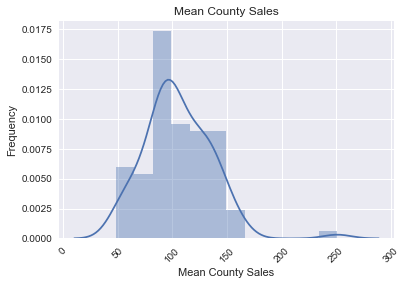

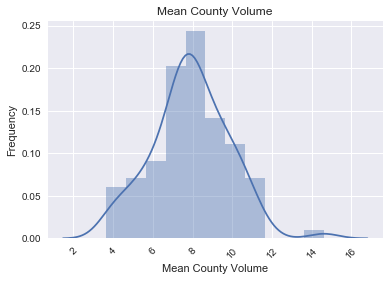

In [30]:
# Mean sales and volume by zip codes
agg_columns = ['Sale_Dollars', 'Volume_Sold_Liters']
county_mean = df_2015.groupby('County')[agg_columns].mean().reset_index()
county_mean.columns = ['County', 'Mean County Sales', 'Mean County Volume']
county_mean_aggs = ['Mean County Sales', 'Mean County Volume']

for i in county_mean_aggs:
    draw_histograms(county_mean, i)
# we get the mean of the data we want to plot and plug that into our function as well as a list of column names

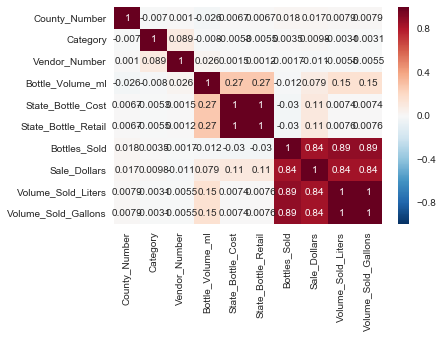

In [31]:
sns.heatmap(df_2015.corr(),annot=True)
## using this do some variable selection

In [32]:
df_cor = df_2015[['County','Bottles_Sold','Sale_Dollars','Volume_Sold_Liters','Store_Number']]
df_cor.head()
# now that I know what varibles I want to model with lets lose the rest for now

,County,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Store_Number
525069,Polk,24,115.92,9.0,3400
525070,Polk,6,68.40,10.5,4165
525071,Polk,6,68.40,10.5,4617
525072,Harrison,2,21.00,1.5,5089
525073,Polk,12,161.64,9.0,4695


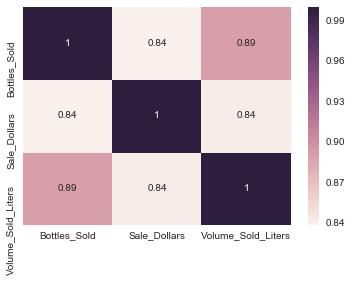

In [33]:
sns.heatmap(df_cor.corr(),annot=True)
# much clearer heatmap. Might put this in presentation. 

In [35]:
hv_county = ('Polk','Black Hawk','Dubuque','Johnson','Linn','Pottawattamie','Scott','Story','Woodbury')
df_hv = df_cor[df_cor.County.isin(hv_county)]
df_hv
# now making a df of the counties and varibles we want, us this to plot to look for regular distribution and make counites DF later

,County,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Store_Number
525069,Polk,24,115.92,9.00,3400
525070,Polk,6,68.40,10.50,4165
525071,Polk,6,68.40,10.50,4617
525073,Polk,12,161.64,9.00,4695
525074,Polk,12,161.64,9.00,4374
525075,Polk,6,63.00,4.50,4725
525076,Scott,60,2265.60,45.00,9002
525077,Polk,12,206.88,9.00,4374
525078,Polk,6,103.44,4.50,4725
525079,Polk,1,37.88,1.00,4165


In [36]:
# df_cor[county_bol == ('Polk','Black Hawk','Dubuque','Johnson','Linn','Pottawattmie','Scott','Story','Woodbury')]

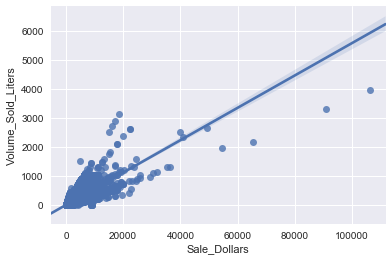

In [37]:
sns.regplot(x="Sale_Dollars", y="Volume_Sold_Liters", data=df_hv)
# look closer at the relationship between volume and price

In [41]:
# county_dumb = pd.get_dummies(df_hv.County)
# df_hv_dumb = pd.concat([df_hv, county_dumb], axis=1)
# sns.pairplot(df_hv_dumb)
# tried to dummy my 9 counties decided against it

In [42]:
#instead I made 9 sperate df's to make SLR with, there is a cleaner way to do this but this worked so I stuck with it
Black_Hawk_county = ("Black Hawk", " ")
df_Black_Hawk = df_hv[df_hv.County.isin(Black_Hawk_county)]
df_Black_Hawk.shape

(120735, 5)

In [43]:
Polk_county = ("Polk", " ")
df_Polk = df_hv[df_hv.County.isin(Polk_county)]
df_Polk.shape

(393822, 5)

In [44]:
Dubuque_county = ("Dubuque", " ")
df_Dubuque = df_hv[df_hv.County.isin(Dubuque_county)]
df_Dubuque.shape

(62107, 5)

In [45]:
Johnson_county = ("Johnson", " ")
df_Johnson = df_hv[df_hv.County.isin(Johnson_county)]
df_Johnson.shape

(108639, 5)

In [46]:
Linn_county = ("Linn", " ")
df_Linn = df_hv[df_hv.County.isin(Linn_county)]
df_Linn.shape

(187577, 5)

In [162]:
Pottawattamie_county = ("Pottawattamie", " ")
df_Pottawattamie = df_hv[df_hv.County.isin(Pottawattamie_county)]
df_Pottawattamie.shape

(73810, 5)

In [48]:
Scott_county = ("Scott", " ")
df_Scott = df_hv[df_hv.County.isin(Scott_county)]
df_Scott.shape

(134529, 5)

In [49]:
Story_county = ("Story", " ")
df_Story = df_hv[df_hv.County.isin(Story_county)]
df_Story.shape

(72591, 5)

In [50]:
Woodbury_county = ("Woodbury", " ")
df_Woodbury = df_hv[df_hv.County.isin(Woodbury_county)]
df_Woodbury.shape

(69030, 5)

(275675, 1) (275675,)
(118147, 1) (118147,)
Cross-Predicted Accuracy: 0.73325726929
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                 7.691e+05
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        00:14:31   Log-Likelihood:            -1.9648e+06
No. Observations:              275675   AIC:                         3.930e+06
Df Residuals:                  275673   BIC:                         3.930e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

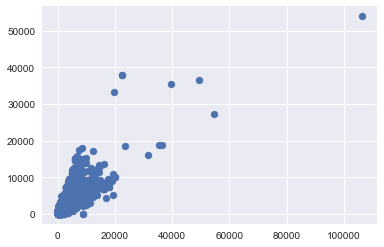

In [141]:
# story time, I was trying to build my models when I googled an error and bad output I was getting. It led me to someones git 
# that had this function, I read through it and fell in love. I know its not mine but I am a big fan. Now I got rid of 
# of vif becuase I dont really know what it does.

def create_linear_model(features, target, seed):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state = seed)
    # here we set up our kfolds with train test split, and something I love is that your seed is a func input
    print X_train.shape, y_train.shape
    print X_test.shape, y_test.shape
    # here we are checking that our splits are the same shape which is a must
    l_model = linear_model.LinearRegression()
    # now we get our model read using Scikitlearn at first
    model = l_model.fit(X_train, y_train)
    i = 10
    scores = cross_val_score(model, X_train, y_train, cv=i)
    # Make cross validated predictions
    predictions = cross_val_predict(model, X_train, y_train, cv=i)
    plt.scatter(y_train, predictions)
    # plot our predictions and y target training
    accuracy = metrics.r2_score(y_train, predictions)
    # here we calaculate a r2 accuracy score
    print "Cross-Predicted Accuracy:", accuracy
    #This is what really sold me on this function, becuase Sci and Stats bring diffrent things to the table but this function lets me run 
    #both each time and get both of thier great outputs
    X_train_sm = sm.add_constant(X_train)
    sm_model = sm.OLS(y_train, X_train_sm).fit()
    #so we set our constant and run our model
    print sm_model.summary()
#     vif = [variance_inflation_factor(X_train_sm.values, ix) for ix in range(X_train_sm.shape[1])] 
#     print "VIF:", vif
# again I am not clear what vif is telling me so I moved it to comments
    return X_train, X_test, y_train, y_test, l_model
test_variables = ["Volume_Sold_Liters"] #this step on not sure why it is neccesary but I couldnt not get it to work without it
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Polk[test_variables], df_Polk["Sale_Dollars"], 100)

(48321, 1) (48321,)
(20709, 1) (20709,)
Cross-Predicted Accuracy: 0.732861525602
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 1.366e+05
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:26:13   Log-Likelihood:            -3.2085e+05
No. Observations:               48321   AIC:                         6.417e+05
Df Residuals:                   48319   BIC:                         6.417e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

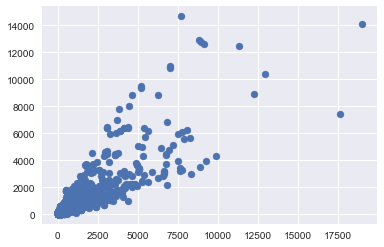

In [52]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Woodbury[test_variables], df_Woodbury["Sale_Dollars"], 100)

(84514, 1) (84514,)
(36221, 1) (36221,)
Cross-Predicted Accuracy: 0.685495525041
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                 1.854e+05
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:26:14   Log-Likelihood:            -5.6445e+05
No. Observations:               84514   AIC:                         1.129e+06
Df Residuals:                   84512   BIC:                         1.129e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

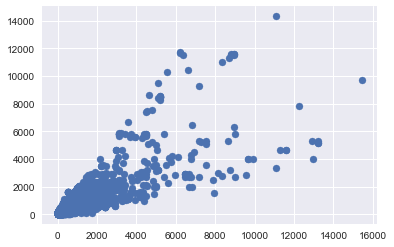

In [53]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Black_Hawk[test_variables], df_Black_Hawk["Sale_Dollars"], 100)

(43474, 1) (43474,)
(18633, 1) (18633,)
Cross-Predicted Accuracy: 0.680946110093
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                 9.387e+04
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:26:15   Log-Likelihood:            -2.8209e+05
No. Observations:               43474   AIC:                         5.642e+05
Df Residuals:                   43472   BIC:                         5.642e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

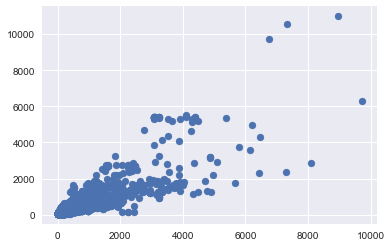

In [54]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Dubuque[test_variables], df_Dubuque["Sale_Dollars"], 100)

(76047, 1) (76047,)
(32592, 1) (32592,)
Cross-Predicted Accuracy: 0.663677643922
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                 1.544e+05
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        00:16:57   Log-Likelihood:            -5.3641e+05
No. Observations:               76047   AIC:                         1.073e+06
Df Residuals:                   76045   BIC:                         1.073e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

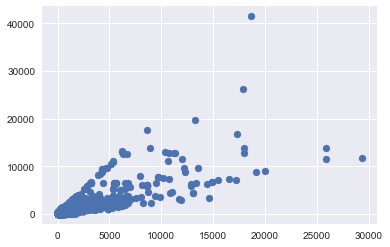

In [143]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Johnson[test_variables], df_Johnson["Sale_Dollars"], 100)

(131303, 1) (131303,)
(56274, 1) (56274,)
Cross-Predicted Accuracy: 0.691892293698
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                 3.019e+05
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:26:17   Log-Likelihood:            -9.0525e+05
No. Observations:              131303   AIC:                         1.811e+06
Df Residuals:                  131301   BIC:                         1.811e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

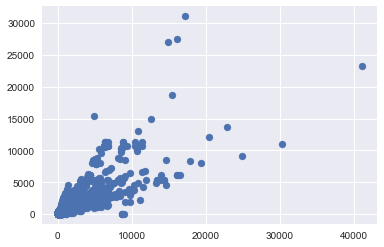

In [56]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Linn[test_variables], df_Linn["Sale_Dollars"], 100)

(51667, 1) (51667,)
(22143, 1) (22143,)
Cross-Predicted Accuracy: 0.685338588385
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                 1.159e+05
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:26:18   Log-Likelihood:            -3.4438e+05
No. Observations:               51667   AIC:                         6.888e+05
Df Residuals:                   51665   BIC:                         6.888e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

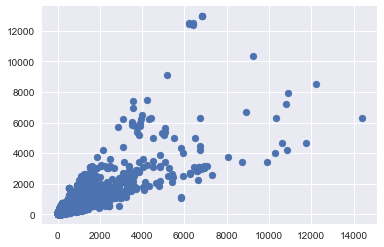

In [57]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Pottawattamie[test_variables], df_Pottawattamie["Sale_Dollars"], 100)

(94170, 1) (94170,)
(40359, 1) (40359,)
Cross-Predicted Accuracy: 0.685116681507
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                 2.065e+05
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        00:16:50   Log-Likelihood:            -6.4186e+05
No. Observations:               94170   AIC:                         1.284e+06
Df Residuals:                   94168   BIC:                         1.284e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

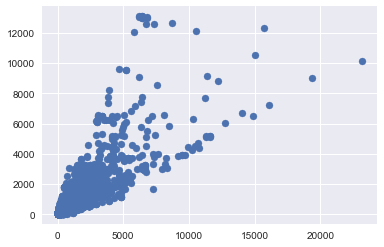

In [142]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Scott[test_variables], df_Scott["Sale_Dollars"], 100)

(50813, 1) (50813,)
(21778, 1) (21778,)
Cross-Predicted Accuracy: 0.677704543431
                            OLS Regression Results                            
Dep. Variable:           Sale_Dollars   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 1.077e+05
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:26:20   Log-Likelihood:            -3.3338e+05
No. Observations:               50813   AIC:                         6.668e+05
Df Residuals:                   50811   BIC:                         6.668e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

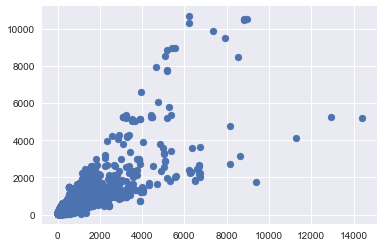

In [59]:
X_train, X_test, y_train, y_test, lm = create_linear_model(df_Story[test_variables], df_Story["Sale_Dollars"], 100)

In [60]:
# 'Polk','Black Hawk','Dubuque','Johnson','Linn','Pottawattmie','Scott','Story','Woodbury'

In [159]:
print df_Johnson.groupby('Store_Number').Sale_Dollars.describe()
print df_Johnson.groupby('County').Sale_Dollars.describe()
print "numeber of store: " + str(df_Johnson.Store_Number.nunique())

                count         mean          std     min      25%      50%  \
Store_Number                                                                
2285           2981.0   259.924995   371.285623    3.16  108.000  179.280   
2512          14256.0   291.234051   708.740761    1.58   77.400  135.000   
2513           6940.0    93.547565   245.387897    4.95   30.390   61.200   
2545           7174.0    71.809141   236.403942    4.95   22.280   41.080   
2599            413.0   185.529395   456.152584    4.95   62.280  110.520   
2622           5763.0   129.961187   325.538629    4.95   45.000   84.960   
2670          12313.0   194.807875   389.755990    4.95   66.000  116.940   
2844            790.0   105.954810    65.745366    8.66   63.015   96.840   
3565           2720.0    73.561643   225.576685    4.95   24.600   41.640   
3670           3546.0   154.693063   134.814969   21.64   87.120  130.920   
3822           1206.0    40.068101    44.413266    3.33   15.750   26.250   

In [160]:
print df_Scott.groupby('Store_Number').Sale_Dollars.describe()
print df_Scott.groupby('County').Sale_Dollars.describe()
print "numeber of store: " + str(df_Scott.Store_Number.nunique())

                count         mean          std      min        25%       50%  \
Store_Number                                                                    
2554           1886.0   119.818727   127.166129    22.50    66.8550    98.940   
2567           7767.0    59.727576   167.313564     1.34    12.3000    21.570   
2603          11089.0   119.701482   274.300355     4.95    32.9800    64.800   
2614          10698.0   150.571997   471.213483     4.83    29.8800    62.280   
2625           9771.0   196.326844   532.329701     1.46    29.8800    74.400   
2635           7482.0   147.556008   315.132983     1.56    60.1200    99.240   
2637           6263.0   142.878969   374.814342     4.95    60.7200    88.500   
2838            478.0   125.559582   346.261716    12.38    56.6475    94.500   
2839            341.0   152.280352   478.743065     9.36    68.5200   106.500   
2840            964.0   108.584927   457.379988     9.00    37.1625    67.260   
3354           3360.0   707.

In [161]:
print df_Polk.groupby('Store_Number').Sale_Dollars.describe()
print df_Polk.groupby('County').Sale_Dollars.describe()
print "numeber of store: " + str(df_Polk.Store_Number.nunique())

                count        mean          std    min       25%      50%  \
Store_Number                                                               
2190          12789.0   95.424489   196.863892   4.35   21.2400   41.760   
2238            526.0  199.011464   258.613446   5.01   40.5000  124.560   
2248           4599.0  143.311855   154.469935   1.58   50.2600   94.520   
2478            903.0  219.720221   172.576108   7.13   81.3650  188.880   
2502           7674.0  178.610532   450.438613   4.95   59.6400   90.000   
2521           7823.0  143.615961   352.955047   5.88   53.8800   86.080   
2527           4896.0  127.833442   304.702933   3.11   55.0000   80.640   
2528           6307.0  159.008511   400.613972   1.34   67.0500  106.500   
2532           4423.0  131.183258   246.260305   2.94   64.5600   99.000   
2535           5008.0  133.224403   250.577897   1.73   56.4600   89.700   
2536           6127.0  118.076977   283.787665   2.94   42.5200   77.040   
2548        

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

### Finally I ran some additonal summary stats on store number to get a better fell for how stores are doing in my prefferd markets. At the end of the day I chose #2 becuase it seemed more engaging and challenging. In this end it was but for the reasons I thought. I just dont feel comfortable with the information here to make a firm recomendation on which county to build a store in. However I do feel I can say that a new store in Polk, Scott or Johnson counties should at least do as well as the average in those counties.